In [2]:
#!/usr/bin/env python
# coding: utf-8

import sys
import os
#print(os.environ['LD_LIBRARY_PATH'])
os.environ['LD_LIBRARY_PATH']='/data/lmp/anaconda3/envs/siamese-mask-rcnn/lib/'
print(os.environ['LD_LIBRARY_PATH'])

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()

#COCO_DATA = 'data/coco/'
COCO_DATA = 'data/severstal-steel-defect-detection'
MASK_RCNN_MODEL_PATH = 'lib/Mask_RCNN/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)

from samples.coco import coco
from mrcnn import utils

from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images, display_differences

from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config

from lib import metrics as metrics

import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict
from natsort import natsorted as nt
import sklearn

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/data/lmp/anaconda3/envs/siamese-mask-rcnn/lib/


### Dataset

In [4]:
# train_classes = coco_nopascal_classes
train_classes = np.array(range(1,5))

In [5]:
# Load COCO/val dataset
coco_val = siamese_utils.IndexedCocoDataset()
coco_object = coco_val.load_coco(COCO_DATA, "val", year="test26v2", return_coco=True)
coco_val.prepare()
coco_val.build_indices()
coco_val.ACTIVE_CLASSES = train_classes

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


### Model

In [6]:
class SmallEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100

#### Select small or large model config

In [7]:
# The small model trains on a single GPU and runs much faster.
# The large model is the same we used in our experiments but needs multiple GPUs and more time for training.
model_size = 'small' # or 'large'

In [8]:
if model_size == 'small':
    config = SmallEvalConfig()
elif model_size == 'large':
    config = LargeEvalConfig()
    
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_DIR                 checkpoints/
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        30
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EXPERIMENT                     evaluation
FPN_CLASSIF_FC_LAYERS_SIZE     512
FPN_FEATUREMAPS                256
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 2.0, 'rpn_bbox_loss': 0.1, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_loss': 0

In [9]:
# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
train_schedule = OrderedDict()
if model_size == 'small':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[25] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
    train_schedule[50] = {"learning_rate": config.LEARNING_RATE / 10, "layers": "all"}
elif model_size == 'large':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[240] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
    train_schedule[320] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}

In [10]:
# Select checkpoint
if model_size == 'small':
    checkpoint = '/data/lmp/code/siamese-mask-rcnn/logs/siamese_mrcnn_small_coco_severstal4classv2/siamese_mrcnn_0050.h5'
elif model_size == 'large':
    checkpoint = 'checkpoints/large_siamese_mrcnn_coco_full_0320.h5'

### Evaluation & Visualization

In [11]:
# Load and evaluate model
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)
# Evaluate only active classes
active_class_idx = np.array(coco_val.ACTIVE_CLASSES) - 1

# Evaluate on the validation set
print('starting evaluation ...')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
loading /data/lmp/code/siamese-mask-rcnn/logs/siamese_mrcnn_small_coco_severstal4classv2/siamese_mrcnn_0050.h5 ...
starting from epoch 50
starting evaluation ...


In [13]:
config.NUM_TARGETS = 1
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)
print("model loaded")

loading /data/lmp/code/siamese-mask-rcnn/logs/siamese_mrcnn_small_coco_severstal4classv2/siamese_mrcnn_0050.h5 ...
starting from epoch 50
model loaded


In [14]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    fig.tight_layout()
    return ax

In [24]:
# Select category
category = 4

ids = nt([{image['id']:i} for i, image in enumerate(coco_val.image_info) if i in coco_val.category_image_index[category]])
print(ids)

[{'0c888ecb5.jpg': 616}, {'01afbfa7a.jpg': 106}, {'1e742caeb.jpg': 631}, {'1ef27af60.jpg': 398}, {'3b8d1d356.jpg': 622}, {'3f3b0ba51.jpg': 196}, {'4aa9afc78.jpg': 151}, {'04fa19d59.jpg': 320}, {'5b1b444e3.jpg': 440}, {'5e5f3ea95.jpg': 299}, {'6fa9e1d65.jpg': 483}, {'7f8d10098.jpg': 562}, {'7f30b9c64.jpg': 329}, {'7ff9e795d.jpg': 152}, {'8d2e8b456.jpg': 266}, {'9c2dc4bfc.jpg': 473}, {'012f26693.jpg': 514}, {'18ace9a9a.jpg': 638}, {'19e918673.jpg': 53}, {'25f9a8622.jpg': 367}, {'36ee3149e.jpg': 493}, {'37ea06e86.jpg': 492}, {'48c466789.jpg': 127}, {'53e812ced.jpg': 412}, {'59f0c09bb.jpg': 552}, {'65b962305.jpg': 16}, {'73e1969d4.jpg': 289}, {'77e5c398e.jpg': 595}, {'0218c0fcc.jpg': 81}, {'354bf035a.jpg': 474}, {'369ac4b0a.jpg': 658}, {'374d9c63f.jpg': 251}, {'479ec009a.jpg': 645}, {'889c66e18.jpg': 425}, {'2490c490c.jpg': 606}, {'2731f7830.jpg': 576}, {'3933a5fcc.jpg': 387}, {'0030401a5.jpg': 612}, {'39960c9e9.jpg': 643}, {'48626da29.jpg': 587}, {'75070e973.jpg': 38}, {'83298d267.jpg': 1

### Seleccionar imagen aleatoria o una especifica
 Ejecutar una de las dos celdas

In [25]:
# primera imagen de la lista
image_id = list(ids[0].values())[0]
print(image_id)

616


In [29]:
#imagen aleatoria
image_id = list(np.random.choice(ids).values())[0]
print(image_id)

547


Carga de la información de la imagen

In [30]:
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(coco_val, config, image_id, use_mini_mask=False)
info = coco_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, coco_val.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

log("original_image", image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image ID: coco.92932546c.jpg (547) http://cocodataset.org/#explore?id=92932546c.jpg
Original image shape:  [ 256 1600    3]
original_image           shape: (512, 512, 3)         min:    0.00000  max:  250.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1600.00000  float64
gt_class_id              shape: (3,)                  min:    3.00000  max:    4.00000  int32
gt_bbox                  shape: (3, 4)                min:   66.00000  max:  341.00000  int32
gt_mask                  shape: (512, 512, 3)         min:    0.00000  max:    1.00000  bool


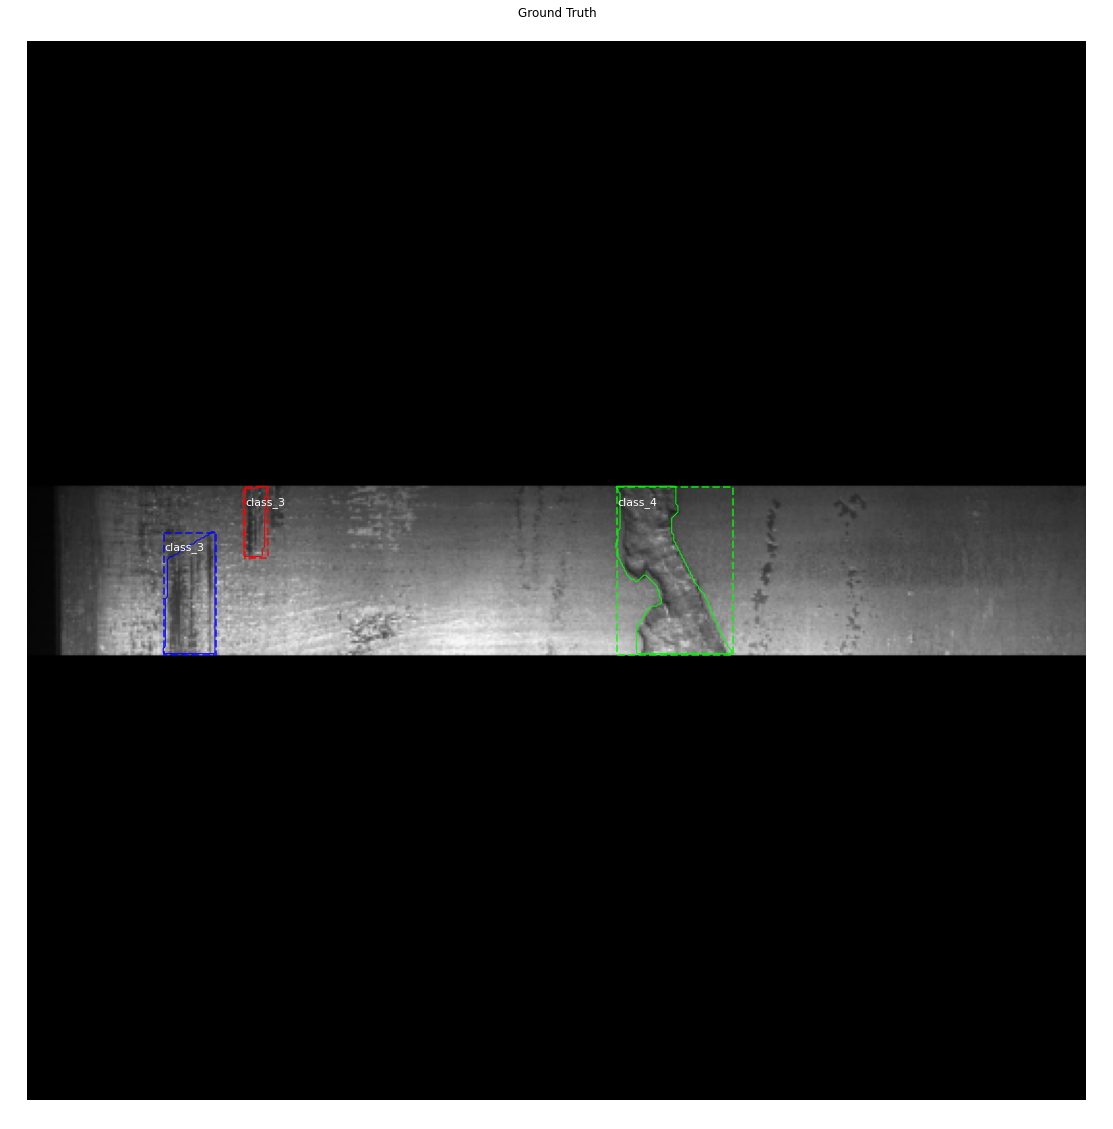

In [33]:
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id,
                             coco_val.class_names, ax=get_ax(1),
                             show_bbox=True, show_mask=False,
                             title="Ground Truth")

### Usando la misma imagen como target

In [34]:
target, window, scale, padding, crop, random_image_id, box_ind = siamese_utils.get_same_target(image_id, category, coco_val, config, return_all=True)
print("target", random_image_id)


target 547


In [36]:
results = model.detect([[target]], [image], verbose=1)
r = results[0]

log("pred_box", r['rois'])
log("pred_mask", r['masks'])

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  250.00000  uint8
target                   shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  211.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
molded_targets           shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  211.00000  uint8
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
pred_box                 shape: (6, 4)                min:   49.00000  max:  408.00000  int32
pred_mask                shape: (512, 512, 6)         min:    0.00000  max:    1.00000  bool


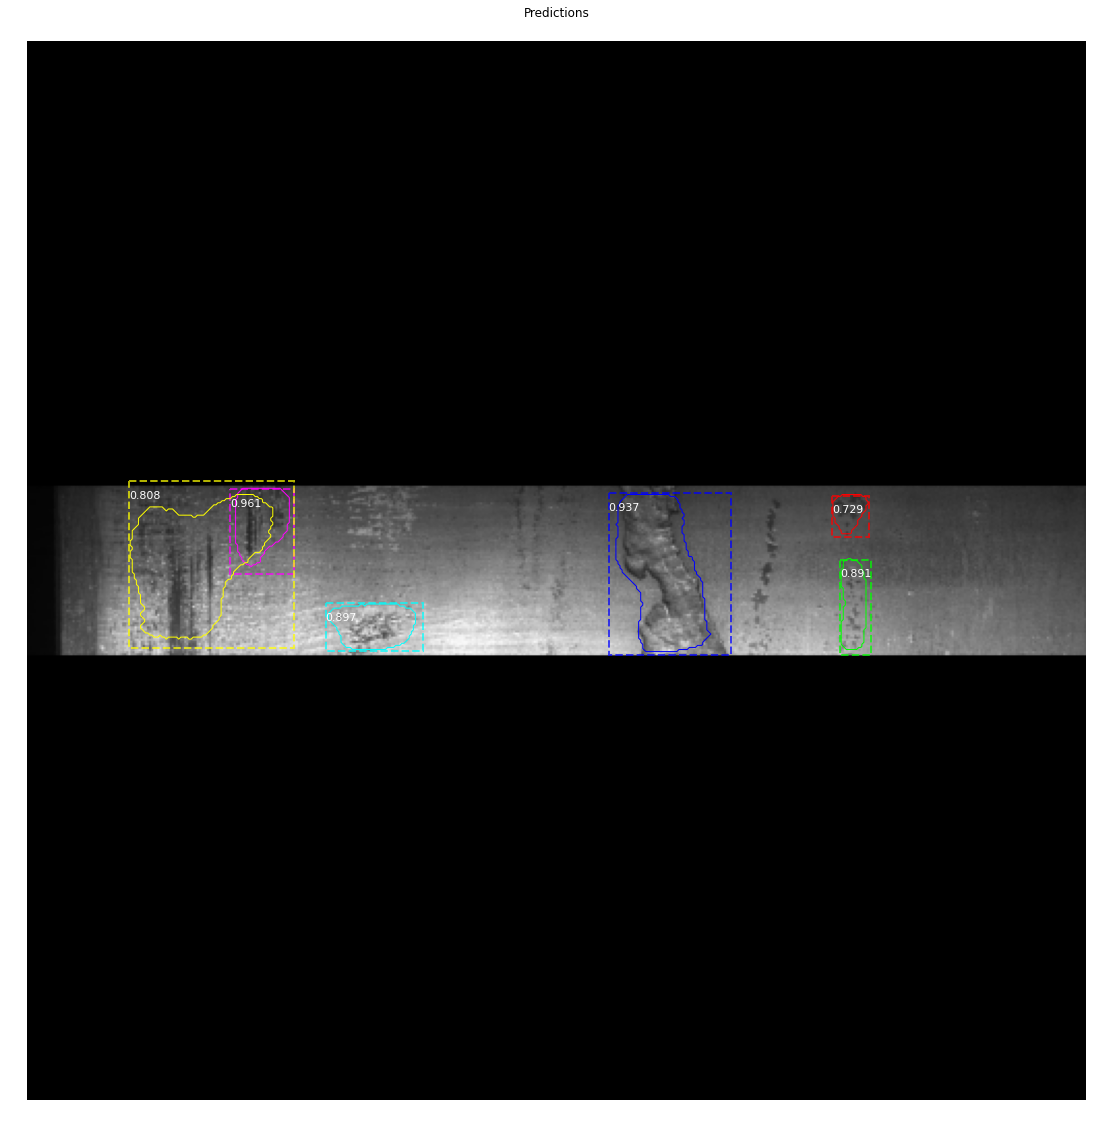

In [38]:
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                             coco_val.class_names, r['scores'], ax=get_ax(1),
                             show_bbox=True, show_mask=False,
                             title="Predictions")

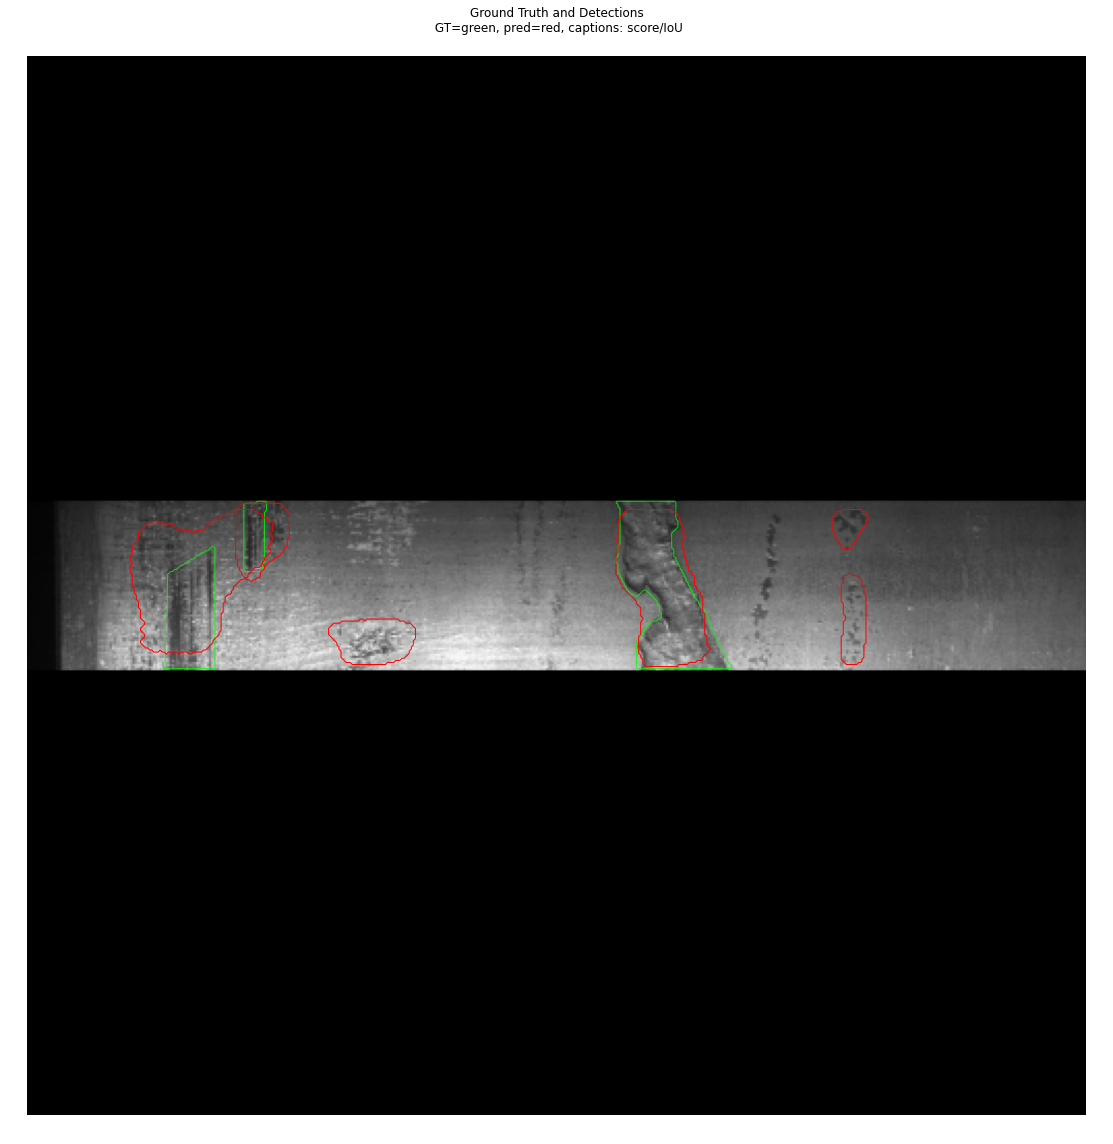

In [39]:
visualize.display_differences2(image, gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'],coco_val.class_names,
                              ax=get_ax(), show_box=False, show_mask=False, iou_threshold=0.5, score_threshold=0.5)

Obtención del coeficiente DICE

In [40]:
b = np.where(gt_class_id == category)[0]

dice = metrics.dice_coef(gt_mask, r['masks'], b)
print("dice", dice)

dice 0.4213528932355338


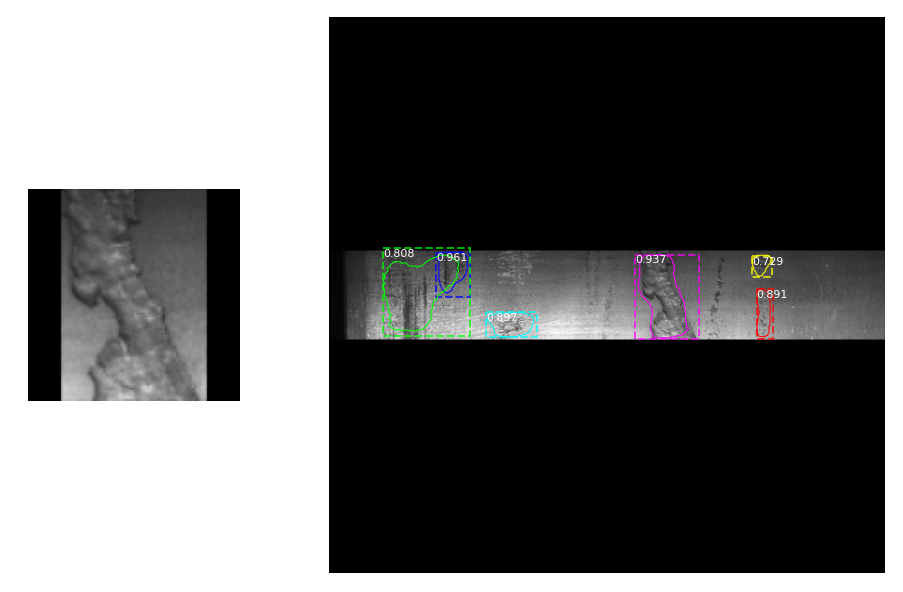

In [41]:
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'],show_mask=False, show_bbox=True)

### Usando una imagen al azar como target

In [55]:
image_rd = list(np.random.choice(ids).values())[0]

imager, image_metar, gt_class_idr, gt_bboxr, gt_maskr = modellib.load_image_gt(coco_val, config, image_rd, use_mini_mask=False)

print("image IDrd: {}.{} ({}) {}".format(info["source"], info["id"], image_rd, coco_val.image_reference(image_rd)))

image IDrd: coco.92932546c.jpg (106) http://cocodataset.org/#explore?id=01afbfa7a.jpg


In [60]:
class_ind = np.where(gt_class_idr == category)[0]
print(class_ind)
gt = gt_maskr[:,:,class_ind]

resultsrd = model.detect([[target]], [imager], verbose=1)
rd = resultsrd[0]

[0]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  134.00000  uint8
target                   shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  211.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   30.10000  float64
molded_targets           shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  211.00000  uint8
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


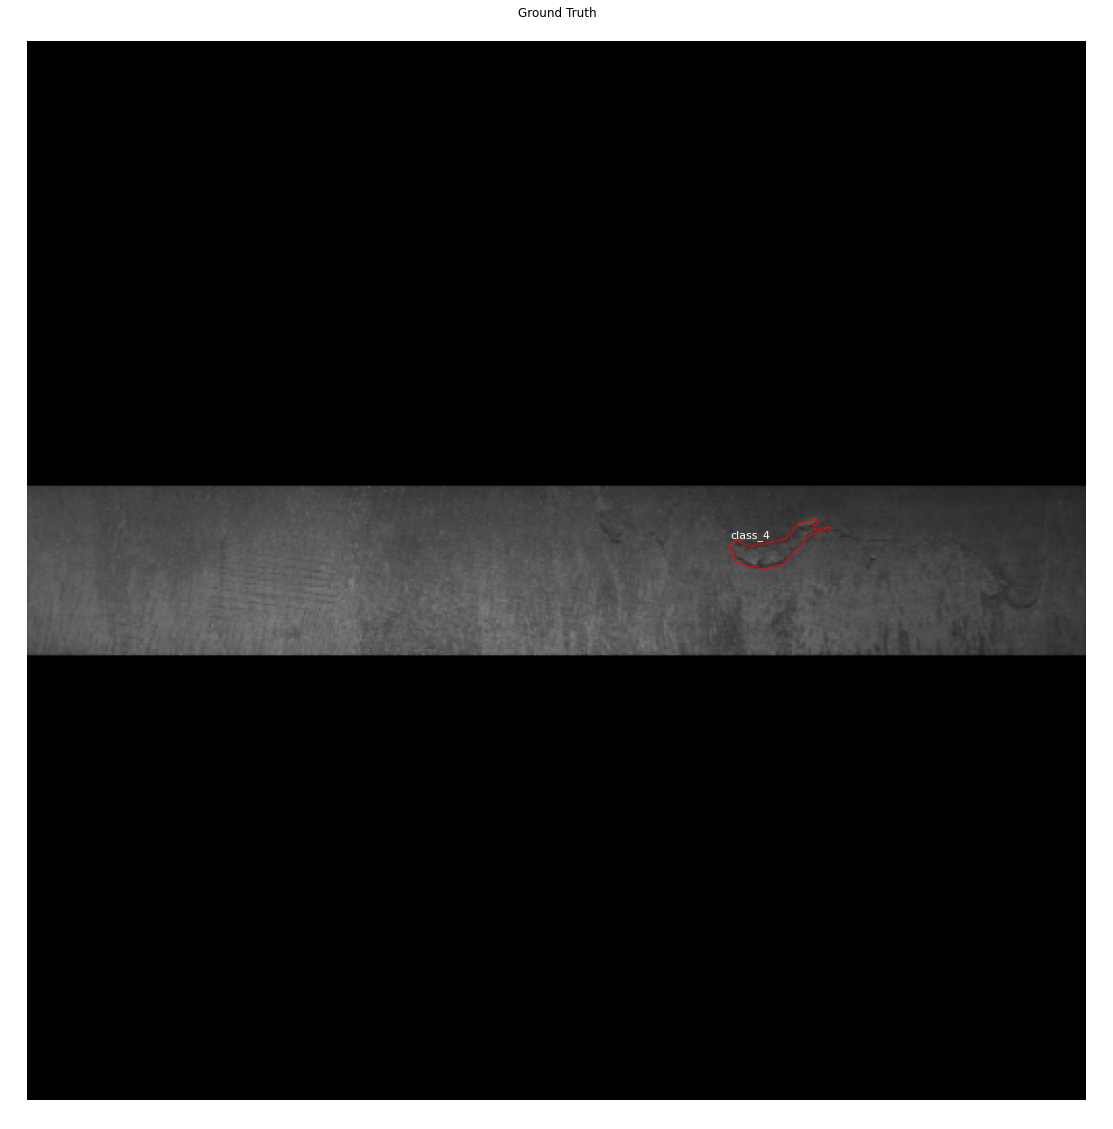

In [61]:
# Display GT
visualize.display_instances(imager, gt_bboxr, gt_maskr, gt_class_idr,
                             coco_val.class_names, ax=get_ax(1),
                             show_bbox=False, show_mask=False,
                             title="Ground Truth")

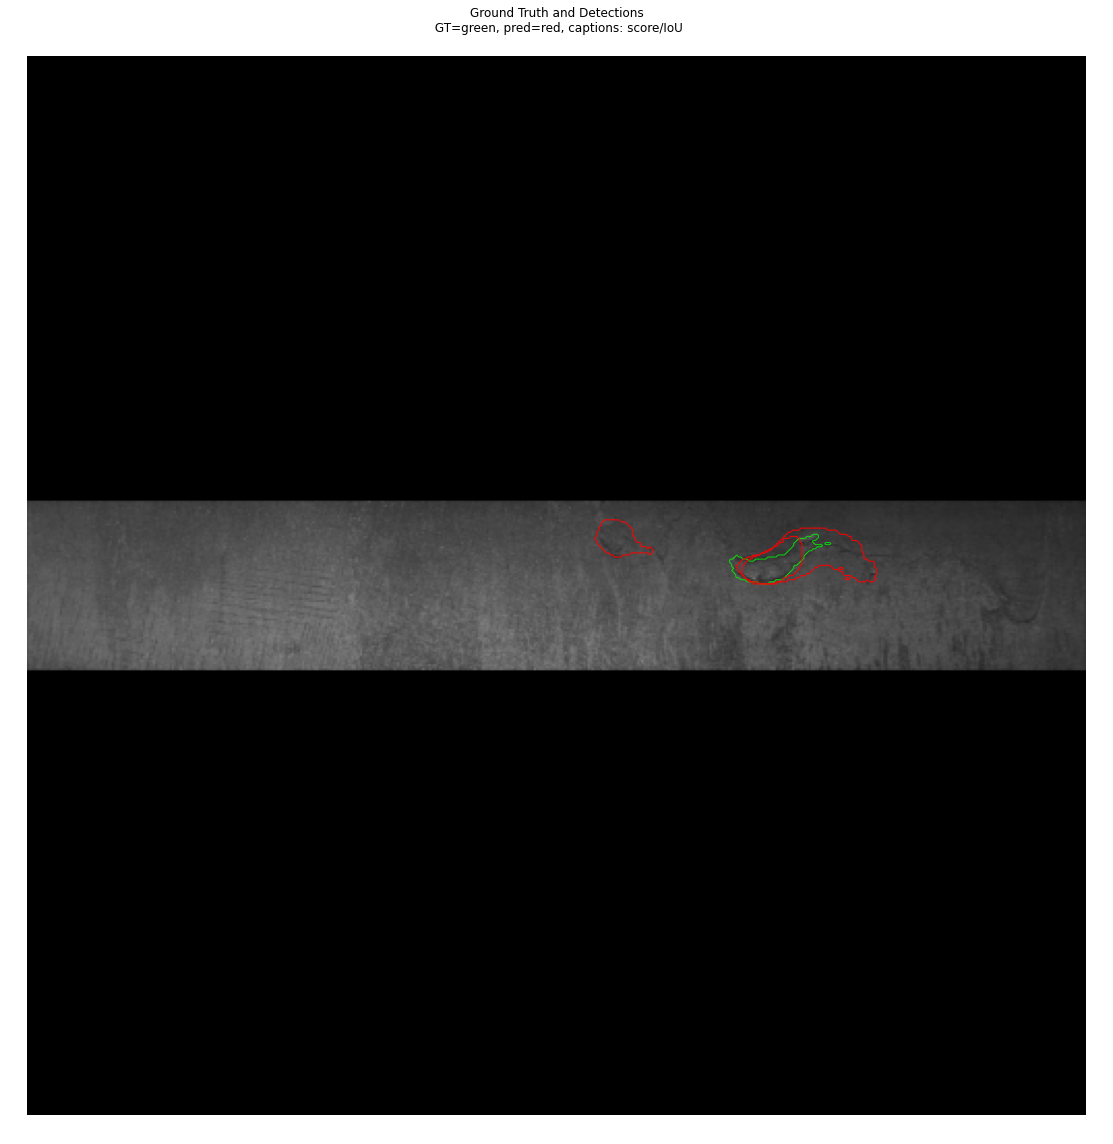

In [62]:
visualize.display_differences2(imager, gt_bboxr, gt_class_idr, gt,
                              rd['rois'], rd['class_ids'], rd['scores'], rd['masks'], coco_val.class_names,
                              ax=get_ax(), show_box=False, show_mask=False, iou_threshold=0.5, score_threshold=0.5)

In [63]:
b = np.where(gt_class_idr == category)[0]

dice = metrics.dice_coef(gt_maskr, rd['masks'], b)
print("dice", dice)

dice 0.41981885988279166


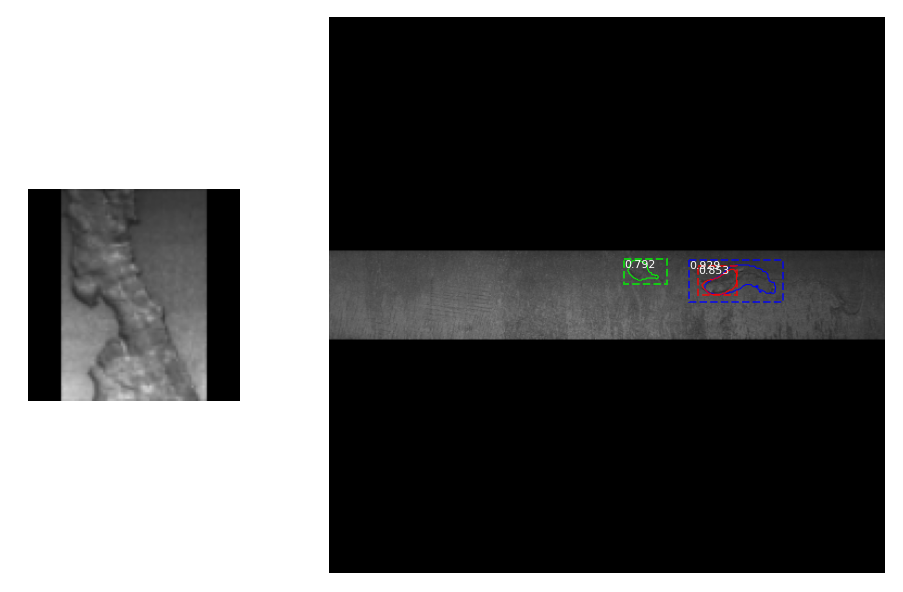

In [64]:
siamese_utils.display_results(target, imager, rd['rois'], rd['masks'], rd['class_ids'], rd['scores'],show_mask=False, show_bbox=True)